In [1]:
import random

import math
import numpy as np

import torch

import matplotlib.pyplot as plt

from tqdm import tqdm

import pandas as pd

import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings|

In [2]:
def ff3(x, noise_std=0):
    n, d = x.size()
    center = torch.tensor([0.], dtype=x.dtype).unsqueeze(-2)
    return 0.5 * (x - center).square().sum(dim=-1) + noise_std * torch.randn(n, device=x.device)

def ff1(x, noise_std=0):
    n, d = x.size()
    center = torch.tensor([2.], dtype=x.dtype).unsqueeze(-2)
    return -torch.exp(- (x - center).square() / 2).sum(dim=-1) + noise_std * torch.randn(n, device=x.device)

def ff2(x, noise_std=1e-2):
    n, d = x.size()
    return torch.pow(x, 4).sum(dim=-1) + noise_std * torch.randn(n, device=x.device)

def L_huber(theta, x, delta = 5.0):
    n, d = theta.size()
    residual = theta - x
    residual = torch.abs(residual)
    
    sol = residual.sum(dim=1)

    # Compute Huber loss element-wise
    abs_residual = torch.abs(residual)
    huber_loss = torch.where(
        abs_residual <= delta,
        0.5 * residual**2,
        delta * abs_residual - 0.5 * delta**2
    )

    # Sum the Huber loss over all dimensions
    sol = huber_loss.sum(dim=1)

    return sol


def huber(theta, data, delta=1.0, noise_std=0):

    n, d = theta.size()
    residual = theta.unsqueeze(1) - data

    # Compute Huber loss element-wise
    abs_residual = torch.abs(residual)
    huber_loss = torch.where(
        abs_residual <= delta,
        0.5 * residual**2,
        delta * abs_residual - 0.5 * delta**2
    )

    # Sum the Huber loss over all dimensions
    sol = -huber_loss.sum(dim=1).sum(dim=1) / 2

    # Add noise term if specified
    if noise_std > 0:
        sol += noise_std * torch.randn(n)

    return sol

def gaussian_log_likelihood(theta, data, noise_std=0):
    n, d = theta.size()
    sol = - (theta.unsqueeze(1) - data).square().sum(dim = 1).sum(dim = 1) / 2
    return sol + noise_std * torch.randn(n)

def L_gaussian_ll(theta, data, noise_std=0):
    n, d = theta.size()
    sol = - (theta.unsqueeze(1) - data).square().sum(dim =2).T / 2
    return sol + noise_std * torch.randn(n)

def gaussian_log_likelihood_stochastic(theta, data, noise_std=0):
    n, d = theta.size()
    N, D = data.size()
    j = np.random.randint(N)
    sol = (theta - data[j].T).square()
    sol = - sol.sum(dim=-1) / 2
    return sol + noise_std * torch.randn(n)

def gaussian_likelihood(theta, data, noise_std=0):
    n, d = theta.size()
    sol = - (theta.unsqueeze(1) - data).square().sum(dim = 1).sum(dim = 1) / 2
    return torch.exp(sol) + noise_std * torch.randn(n)

def kernel_fn(x1, x2, kernel = 'gaussian'):
    if kernel == 'gaussian':
        return torch.exp(-(x1.unsqueeze(1) - x2.unsqueeze(0)).square().sum(dim = 2) / 2)
    
    elif kernel == 'poly':
        degree = 2  # Adjust degree as needed
        return ((x1.unsqueeze(1) * x2.unsqueeze(0)).sum(dim=2) + 1).pow(degree)


def kernel_grad_fn(x1, x2, kernel = 'gaussian'):
    if kernel == 'gaussian':
        return - (x1 - x2).T * kernel_fn(x1, x2)
    
    elif kernel == 'poly':
        degree = 2  # Adjust degree as needed
        kernel_values = ((x1.unsqueeze(1) * x2.unsqueeze(0)).sum(dim=2) + 1).pow(degree - 1)
        return x2.T * degree * kernel_values

def kernel_grad_grad_fn(x1, x2, kernel = 'gaussian'):
    if kernel == 'gaussian':
        k = kernel_fn(x1, x2)  # Shape (batch_size,)
        v = x1 - x2  # Shape (batch_size, dim)

        v_outer = torch.outer(v.squeeze(), v.squeeze())

        identity = torch.eye(x1.size(-1), device=device)

        hessian = k * (-v_outer + identity)
        
        return hessian
    
    elif kernel == 'poly':
        degree = 2
        k = kernel_fn(x1, x2, kernel='poly')  # Shape (batch_size, batch_size)
        dot_products = (x1.unsqueeze(1) * x2.unsqueeze(0)).sum(dim=2) + 1  # Shape (batch_size, batch_size)
        
        grad = degree * dot_products.pow(degree - 1)  # First-order gradient factor
        
        hessian = degree * (degree - 1) * dot_products.pow(degree - 2).unsqueeze(-1).unsqueeze(-1) * (
            x2.unsqueeze(0).unsqueeze(-1) @ x2.unsqueeze(0).unsqueeze(-2)
        ) + grad.unsqueeze(-1).unsqueeze(-1) * torch.eye(x1.size(-1)).unsqueeze(0).unsqueeze(0)
        return hessian.squeeze()

def get_posterior_variance_of_gradient(x, z, kernel = 'gaussian'):
    
    K_xx = kernel_grad_grad_fn(x, x, kernel = kernel)
    K_xz = kernel_grad_fn(x, z, kernel = kernel)
    K_zz = kernel_fn(z, z, kernel = kernel)
    # K_zz = K_zz @ K_zz
    
    jitter = 1e-6 * 5 # This value can be tuned depending on the problem
    
    L = torch.cholesky(K_zz + (jitter) * torch.eye(K_zz.size(-1), device=device))
    v = torch.cholesky_solve(K_xz.T, L)
    
    result = K_xx - torch.matmul(K_xz, v)
    
    return result

def get_posterior_mean_of_gradient(x, z, kernel = 'gaussian'):
    
    K_xz = kernel_grad_fn(x, z, kernel = kernel)
    K_zz = kernel_fn(z, z, kernel = kernel)
    y = ff(z).unsqueeze(-1)
    
    jitter = 1e-9  # This value can be tuned depending on the problem
    
    L = torch.cholesky(K_zz + (jitter) * torch.eye(K_zz.size(-1), device=device))
    v = torch.cholesky_solve(y, L)

    result = torch.matmul(K_xz, v)
    
    return result

def alpha_trace(x, z, kernel = 'gaussian'):
    
    result = get_posterior_variance_of_gradient(x, z, kernel = kernel)
    # result = rotation_matrix @ result
    trace = result.diag().sum()
    
    return trace

def get_points(x, batch_size, D = torch.empty(0), kernel = 'gaussian'):
    
    d = x.size(-1)
    z = x + 1e-5 / math.sqrt(d) * torch.randn(batch_size, d, dtype=x.dtype, device = device) #starting point for z
    z = z.clone().detach().requires_grad_(True) #turn on gradietns since we optimize over z
    
    optimizer = torch.optim.Adam([z], lr=0.01)
    # optimizer = FullBatchLBFGS([z], lr=1e-1)
    
    num_iterations = 1000
    for i in range(num_iterations):
        optimizer.zero_grad()

        # loss = alpha_trace(x, z, kernel = kernel) 
        z_D = torch.concat([D, z])
        loss = alpha_trace(x, z_D, kernel = kernel) 
        loss.backward()
        optimizer.step()
        
    return z

In [3]:
def find_closest_points(tensor, point, C):
    """
    Find the C closest points to a given point in a tensor.

    Args:
        tensor (torch.Tensor): The tensor of shape (N, D), where N is the number of points, and D is the dimensionality.
        point (torch.Tensor): A point of shape (D,) to which the distances are calculated.
        C (int): The number of closest points to return.

    Returns:
        torch.Tensor: The C closest points to the given point.
    """
    
    C = np.minimum(tensor.size()[0], C)
    
    if not isinstance(tensor, torch.Tensor) or not isinstance(point, torch.Tensor):
        raise ValueError("Both the tensor and the point must be torch.Tensor instances.")
    
    if tensor.shape[1] != point.shape[0]:
        raise ValueError("The dimensionality of the tensor and the point must match.")

    # Compute Euclidean distances
    distances = torch.norm(tensor - point, dim=1)

    # Find the indices of the C smallest distances
    closest_indices = torch.topk(distances, C, largest=False).indices

    # Extract the C closest points
    closest_points = tensor[closest_indices]

    return closest_points

In [4]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.optimize import Bounds
from scipy.optimize import minimize
import torch

# Load the CT slice dataset
data = pd.read_csv('slice_localization_data.csv')

# Separate inputs (X) and output (y)
X = data.iloc[:, 1:20].values  # All columns except the last are features
y = data.iloc[:, -1].values   # The last column is the response

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=9000, random_state=42)

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

# Define bounds for hyperparameters in log space
n_features = X_train.shape[1]  # Number of features
bounds = Bounds(
    [-3] * n_features + [np.log(0.01), np.log(0.1), np.log(0.01)],
    [3] * n_features + [np.log(1.0), np.log(3.0), np.log(5.0)]
)

# Generate random hyperparameters with specific ranges
def generate_hyperparams(d):
    hyperparams = torch.empty(1, d).uniform_(-3, 3)  # First d-3 entries uniform(-2, 4)
    hyperparams[0, -3] = torch.empty(1).uniform_(np.log(0.01), np.log(1.0))  # Last three entries
    hyperparams[0, -2] = torch.empty(1).uniform_(np.log(0.1), np.log(3.0))
    hyperparams[0, -1] = torch.empty(1).uniform_(np.log(0.01), np.log(5.0))
    return hyperparams

# Objective function: Fit SVR and return validation loss matrix
def objective_batch(batch_log_hyperparams):
    batch_log_hyperparams = np.array(batch_log_hyperparams)
    n = batch_log_hyperparams.shape[0]
    validation_losses = torch.zeros((X_test.shape[0], n), dtype=torch.float64)

    for i, log_hyperparams in enumerate(batch_log_hyperparams):
        log_length_scales = log_hyperparams[:n_features]
        log_epsilon = log_hyperparams[-3]
        log_gamma = log_hyperparams[-2]
        log_C = log_hyperparams[-1]
        # Hyperparameters
        length_scales = np.exp(log_length_scales)
        epsilon = np.exp(log_epsilon)  # Fixed epsilon
        gamma = np.exp(log_gamma)    # Fixed gamma
        C = np.exp(log_C)        # Fixed C

        # Scale features based on length scales
        X_train_scaled = X_train / length_scales
        X_test_scaled = X_test / length_scales

        # Fit SVR
        svr = SVR(kernel="rbf", epsilon=epsilon, gamma=gamma, C=C)
        svr.fit(X_train_scaled, y_train)

        # Predict and compute residuals
        y_pred = svr.predict(X_test_scaled)
        residuals = y_test - y_pred

        # Compute per-user validation loss
        validation_losses[:, i] = torch.tensor(0.5 * np.power(residuals, 2), dtype=torch.float64)

    return validation_losses

# Example usage
d = n_features + 3  # Total dimensions including additional hyperparameters
initial_hyperparams = generate_hyperparams(d)
print("Generated hyperparameters:", initial_hyperparams)


Generated hyperparameters: tensor([[ 2.7964, -1.4322, -2.1326, -2.4699, -2.8867, -2.7668, -1.9734, -2.4639,
         -1.5920, -1.1162,  1.7408,  0.5653,  0.4658,  2.4793,  1.2414,  2.0408,
          2.4105, -1.6197,  0.4751, -3.7928, -1.3582,  1.3338]])


In [6]:
def ff(theta1, noise_std = 0.):
    
    n, d = theta1.size()
    theta1 = torch.tensor(theta1, device = device)
    return objective_batch(theta1)

def run2(mu = 1, bs = d + 1, epsilon = 1, private = True, use_adaptive = False, lr = 1):

    D = torch.empty(0, device=device)
    sigma = 2 * B * np.sqrt(T) / (N * mu)

    theta = torch.rand(1, len(bounds.lb), device = device) * (bounds.ub - bounds.lb) + bounds.lb
    theta = theta_0    
    # theta = torch.empty(1, d, device=device).uniform_(-4., 4.)

    NN_loss = [ff(theta).mean().item()]
    NN_trace = []
    samples_needed = []
    theta_path = [theta[0]]

    # Initialize the historical sum of squared gradients (squared accumulator)
    historical_grad = torch.zeros_like(theta, device=device)

    for iteration in tqdm(range(T)):
        if (iteration > 0):
            D_temp = find_closest_points(D, theta[0], C).detach()
        else:
            D_temp = torch.empty(0)
            
        if use_adaptive:
            sample_counter = 0

            if iteration == 0:
                z = get_points(theta, batch_size = 1, D = D_temp, kernel = kernel)
                D = torch.concat([D, z])
                D_temp = torch.concat([D_temp, z])
                sample_counter += 1

            while (get_posterior_variance_of_gradient(theta, D_temp, kernel = kernel).trace() > epsilon):
                z = get_points(theta, batch_size = 1, D = D_temp, kernel = kernel)
                D = torch.concat([D, z])
                D_temp = torch.concat([D_temp, z])
                sample_counter += 1

            samples_needed.append(sample_counter)
    
        else:
            D_temp = torch.tensor(D_temp, device = device)
            z = get_points(theta, batch_size = bs, D = D_temp, kernel = kernel)
            # z = torch.abs(z)

            z = torch.tensor(z, device=device)
            D = torch.concat([D, z])
            D_temp = torch.concat([D_temp, z])

        gradients = get_posterior_mean_of_gradient(theta, D_temp, kernel = kernel).detach()

        clipped_gradients = gradients * torch.minimum(torch.tensor(1), torch.tensor(B) / torch.norm(gradients, dim = 1, keepdim=True))

        g = clipped_gradients.sum(dim = 0) / N
        # print(g.norm())

        cov = get_posterior_variance_of_gradient(theta, D_temp, kernel = kernel) 
                    
        stepSize = lr

        # # Update step using AdaGrad
        gradient = g.T + sigma * torch.randn(d, device=device)  # Compute the gradient
        historical_grad += gradient**2  # Accumulate squared gradients
        adjusted_step = stepSize / (torch.sqrt(historical_grad) + 1e-8)  # Adaptive step size
        theta = theta - adjusted_step * gradient  # Parameter update
        theta = torch.clamp(theta, min=-5)  # Clamp values
        
        NN_loss.append(ff(theta).mean().item())
        NN_trace.append(cov.trace().item())
        theta_path.append(theta[0])

        
    return NN_loss, theta_path, NN_trace, samples_needed, g.norm()

In [21]:
# Define simulation parameters
d = n_features + 3
num_iterations = 1
path_length = 30
T = path_length 
bs = d + 1
mu = .2
B = .5
N = 9000
C = 0
kernel = 'gaussian'
device = "cpu"

In [8]:
def sample_and_evaluate(T):
    """
    Randomly samples hyperparameters, evaluates the validation loss T times,
    and plots the best guess (lowest validation loss so far) over iterations.

    Parameters:
    - T (int): Number of iterations (hyperparameter samples).
    - X_train (torch.Tensor): Training features of shape (m_train, d).
    - Y_train (torch.Tensor): Training targets of shape (m_train, 1).
    - X_val (torch.Tensor): Validation features of shape (m_val, d).
    - Y_val (torch.Tensor): Validation targets of shape (m_val, 1).
    """
    best_loss_so_far = []
    best_loss = float('inf')  # Initialize the best loss to infinity

    for t in tqdm(range(T)):
        # Randomly sample hyperparameters in R
        # hyperparams = torch.randn(1, 10)  # One set of hyperparameters
        hyperparams = torch.rand(1, len(bounds.lb)) * (bounds.ub - bounds.lb) + bounds.lb

        # Evaluate validation losses
        validation_losses = objective_batch(hyperparams)

        # Compute average validation loss across users
        avg_loss = validation_losses.mean().item()

        # Update the best loss so far
        if avg_loss < best_loss:
            best_loss = avg_loss
        best_loss_so_far.append(best_loss)

    return best_loss_so_far

In [29]:
print(2 * B * np.sqrt(T) / (N * mu))
import os

# Arrays to store losses
losses_dp_gibo = np.zeros((num_iterations, path_length + 1))
losses_dp_gibo2 = np.zeros((num_iterations, path_length + 1))
losses_random = np.zeros((num_iterations, path_length * bs))

# os.makedirs("d100", exist_ok=True)

theta_0 = torch.rand(1, len(bounds.lb), device = device) * (bounds.ub - bounds.lb) + bounds.lb

# Run the simulations
for i in (range(num_iterations)):
    loss, path, trace_path, samples_needed, norm = run2(bs=bs, epsilon = 2, mu = mu, lr = 1.)  # Simulated DP-GIBO loss
    losses_dp_gibo[i, :] = loss

    loss2, path2, trace_path2, samples_needed2, norm2 = run2(bs=bs, epsilon = 2, mu = 10000, lr = 1.)  # Simulated DP-GIBO loss
    losses_dp_gibo2[i, :] = loss2

    # loss_random = sample_and_evaluate(
    #     T=path_length * bs,
    # )
    # losses_random[i, :] = torch.tensor(loss_random)

    print("DP-GIBO", loss[-1])
    print("DP-GIBO2", loss2[-1])
    # print("RANDOM", loss_random[-1])

# np.save(f"d100/losses_dp_gibo.npy", losses_dp_gibo)
# np.save(f"d100/losses_random.npy", losses_random)

0.003042903097250923


100%|██████████| 30/30 [03:48<00:00,  7.63s/it]

DP-GIBO 0.1440074933031785
DP-GIBO2 0.13612444096745457


In [ ]:
# np.save(f"losses_dp_gibo_15May.npy", losses_dp_gibo)
# np.save(f"losses_random_15May.npy", losses_random)
# np.save(f"losses_dp_gibo2_15May.npy", losses_dp_gibo2)

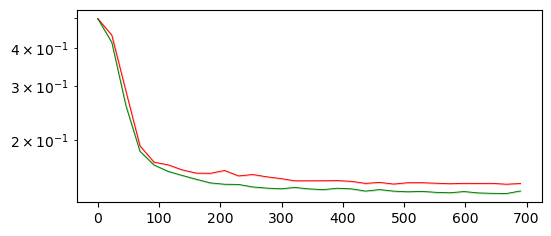

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean and confidence intervals
mean_dp_gibo = losses_dp_gibo.mean(axis=0)
std_dp_gibo = losses_dp_gibo.std(axis=0)
ci_dp_gibo = 1.96 * std_dp_gibo / np.sqrt(num_iterations)  # 95% CI

# Compute mean and confidence intervals
mean_dp_gibo2 = losses_dp_gibo2.mean(axis=0)
std_dp_gibo2 = losses_dp_gibo2.std(axis=0)
ci_dp_gibo2 = 1.96 * std_dp_gibo2 / np.sqrt(num_iterations)  # 95% CI

# mean_random = losses_random.mean(axis=0)
# std_random = losses_random.std(axis=0)
# ci_random = 1.96 * std_random / np.sqrt(num_iterations)  # 95% CI

# Plotting
plt.figure(figsize=(6, 2.5))
plt.yscale('log')

random_length = path_length * bs

# DP-GIBO with confidence intervals (plotted at every 5th point)
x_dp_gibo = np.arange(0, random_length + bs, bs)  # Match the random scale
plt.plot(x_dp_gibo, mean_dp_gibo, label=r'DP-GIBO, $\mu = 1$', color='red', lw=0.7)
plt.fill_between(
    x_dp_gibo,
    mean_dp_gibo - ci_dp_gibo,
    mean_dp_gibo + ci_dp_gibo,
    color='red',
    alpha=0.2
)

plt.plot(x_dp_gibo, mean_dp_gibo2, label=r'DP-GIBO, $\mu = 1$', color='green', lw=0.7)
plt.fill_between(
    x_dp_gibo,
    mean_dp_gibo2 - ci_dp_gibo2,
    mean_dp_gibo2 + ci_dp_gibo2,
    color='green',
    alpha=0.2
)

# # Random with confidence intervals
# x_random = np.arange(random_length)
# plt.plot(x_random, mean_random, label='Random', color='blue', lw=0.7)
# plt.fill_between(
#     x_random,
#     mean_random - ci_random,
#     mean_random + ci_random,
#     color='blue',
#     alpha=0.2
# )

In [68]:
mean_dp_gibo[-1]

0.1629547962978909

In [51]:
norm

tensor(0.0078, dtype=torch.float64)

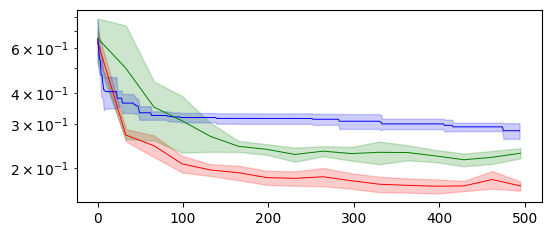

In [40]:
import numpy as np
import matplotlib.pyplot as plt


mean_random = losses_random.mean(axis=0)
std_random = losses_random.std(axis=0)
ci_random = 1.96 * std_random / np.sqrt(num_iterations)  # 95% CI

# Compute mean and confidence intervals
mean_dp_gibo = losses_dp_gibo_inf.mean(axis=0)
std_dp_gibo = losses_dp_gibo_inf.std(axis=0)
ci_dp_gibo = 1.96 * std_dp_gibo / np.sqrt(num_iterations)  # 95% CI

mean_1 = losses_dp_gibo.mean(axis=0)
std_1 = losses_dp_gibo.std(axis=0)
ci_1 = 1.96 * std_1 / np.sqrt(num_iterations)  # 95% CI

# Plotting
plt.figure(figsize=(6, 2.5))
plt.yscale('log')

random_length = path_length * bs

# DP-GIBO with confidence intervals (plotted at every 5th point)
x_dp_gibo = np.arange(0, random_length + bs, bs)  # Match the random scale
plt.plot(x_dp_gibo, mean_dp_gibo, label=r'DP-GIBO, $\mu = 1$', color='red', lw=0.7)
plt.fill_between(
    x_dp_gibo,
    mean_dp_gibo - ci_dp_gibo,
    mean_dp_gibo + ci_dp_gibo,
    color='red',
    alpha=0.2
)

# Random with confidence intervals
x_random = np.arange(random_length)
plt.plot(x_random, mean_random, label='Random', color='blue', lw=0.7)
plt.fill_between(
    x_random,
    mean_random - ci_random,
    mean_random + ci_random,
    color='blue',
    alpha=0.2
)

# Random with confidence intervals
x_random = np.arange(random_length)
plt.plot(x_dp_gibo, mean_1, label='Random', color='green', lw=0.7)
plt.fill_between(
    x_dp_gibo,
    mean_1 - ci_1,
    mean_1 + ci_1,
    color='green',
    alpha=0.2
)

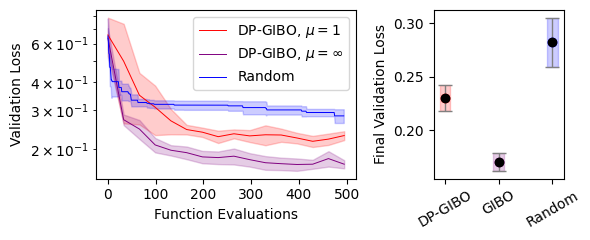

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the following arrays are defined:
# losses_dp_gibo, losses_random, losses_global_BO
# num_iterations, path_length, bs

# Compute mean and confidence intervals for each method
mean_dp_gibo = losses_dp_gibo.mean(axis=0)
std_dp_gibo = losses_dp_gibo.std(axis=0)
ci_dp_gibo = 1.96 * std_dp_gibo / np.sqrt(num_iterations)  # 95% CI

mean_random = losses_random.mean(axis=0)
std_random = losses_random.std(axis=0)
ci_random = 1.96 * std_random / np.sqrt(num_iterations)  # 95% CI

mean_global = losses_dp_gibo_inf.mean(axis=0)
std_global = losses_dp_gibo_inf.std(axis=0)
ci_global = 1.96 * std_global / np.sqrt(num_iterations)  # 95% CI

# Prepare bar plot data for final evaluations
final_means = [
    mean_dp_gibo[-1],
    mean_global[-1],
    mean_random[-1],
]
final_stds = [
    std_dp_gibo[-1],
    std_global[-1],
    std_random[-1],
]
methods = ["DP-GIBO", "GIBO", "Random"]

# Create the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={"width_ratios": [2, 1]})

# First subplot: Original plot with validation loss over evaluations
axes[0].set_yscale("log")
x_dp_gibo = np.arange(0, path_length * bs + bs, bs)
axes[0].plot(x_dp_gibo, mean_dp_gibo, label=r"DP-GIBO, $\mu = 1$", color="red", lw=0.7)
axes[0].fill_between(
    x_dp_gibo,
    mean_dp_gibo - ci_dp_gibo,
    mean_dp_gibo + ci_dp_gibo,
    color="red",
    alpha=0.2,
)

axes[0].plot(x_dp_gibo, mean_global, label=r"DP-GIBO, $\mu = \infty$", color="purple", lw=0.7)
axes[0].fill_between(
    x_dp_gibo,
    mean_global - ci_global,
    mean_global + ci_global,
    color="purple",
    alpha=0.2,
)

x_random = np.arange(path_length * bs)
axes[0].plot(x_random, mean_random, label="Random", color="blue", lw=0.7)
axes[0].fill_between(
    x_random,
    mean_random - ci_random,
    mean_random + ci_random,
    color="blue",
    alpha=0.2,
)

axes[0].set_xlabel("Function Evaluations")
axes[0].set_ylabel("Validation Loss")
axes[0].legend(loc="upper right")
# axes[0].set_title("Validation Loss Over Function Evaluations")

# Second subplot: Final evaluations with std shading
final_x = np.arange(len(methods))
axes[1].errorbar(
    final_x,
    final_means,
    yerr=final_stds,
    fmt="o",
    color="black",
    ecolor="gray",
    elinewidth=1,
    capsize=5,
)

# Use the same colors as the left plot for each method
for i, (mean, std, color) in enumerate(
    zip(final_means, final_stds, ["red", "purple", "blue"])
):
    axes[1].plot([i], [mean], marker="o", color=color, lw=0.3)
    axes[1].fill_between(
        [i - 0.1, i + 0.1],  # Small range around the mean
        [mean - std, mean - std],
        [mean + std, mean + std],
        color=color,
        alpha=0.2,
    )

axes[1].set_xticks(final_x)
axes[1].set_xticklabels(methods, rotation=30)
axes[1].set_ylabel("Final Validation Loss")
# axes[1].set_title("Final Loss Statistics")




# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("combined_plot_SVM.png")
plt.show()


In [32]:
import pickle

# Save tensors in a dictionary
tensors = {"mu1": losses_dp_gibo, "random": losses_random, "mu05": losses_dp_gibo_05, "muinf": losses_dp_gibo_inf}

with open("SVM_d33_good.pkl", "wb") as f:
    pickle.dump(tensors, f)

In [51]:
# Save tensors to files
torch.save(losses_dp_gibo, "losses_dp_gibo.pt")
torch.save(losses_random, "losses_random.pt")
torch.save(losses_dp_gibo_inf, "losses_dp_gibo_inf.pt")

In [2]:
import torch

# Load tensors from files
losses_dp_gibo = torch.load("losses_dp_gibo.pt")
losses_random = torch.load("losses_random.pt")
losses_dp_gibo_inf = torch.load("losses_dp_gibo_inf.pt")

In [7]:
num_iterations = 5
path_length = 15
bs = 33

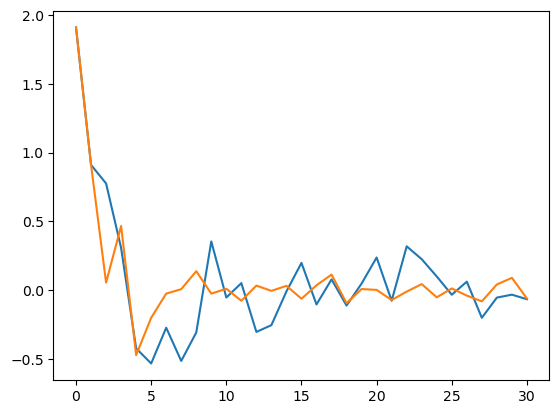

In [59]:
elem = 4
first_elems_list = [t[elem].item() for t in path]
first_elems_np = np.array(first_elems_list)

first_elems_list2 = [t[elem].item() for t in path2]
first_elems_np2 = np.array(first_elems_list2)

plt.plot(first_elems_np)
plt.plot(first_elems_np2)

np.save(f"dp-path1.npy", first_elems_np)
np.save(f"nondp-path1.npy", first_elems_np2)

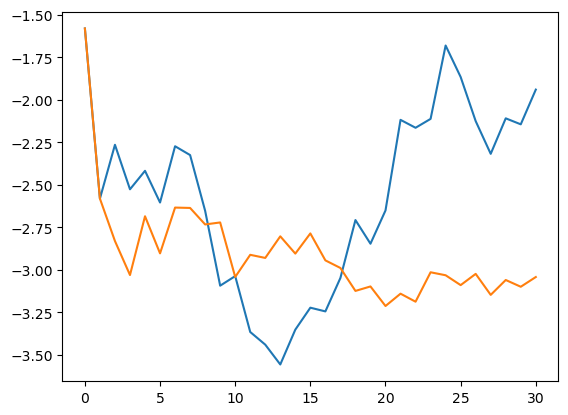

In [60]:
elem = 19
first_elems_list = [t[elem].item() for t in path]
first_elems_np = np.array(first_elems_list)

first_elems_list2 = [t[elem].item() for t in path2]
first_elems_np2 = np.array(first_elems_list2)

plt.plot(first_elems_np)
plt.plot(first_elems_np2)

np.save(f"dp-path2.npy", first_elems_np)
np.save(f"nondp-path2.npy", first_elems_np2)